# Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistrated functional images with FWHM set to 4mm

## Imports

First, let's import all modules we later will be needing.

In [2]:
%matplotlib inline
from os.path import join as opj
import json
import nipype.interfaces.fsl as fsl
from nipype.interfaces.fsl import MCFLIRT, FLIRT
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

171213-11:09:18,906 interface WARNING:
	 Could not get linked libraries for "which".


# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [8]:
data_dir = '/home/neuro/nipype_tutorial/data/'

experiment_dir = '/home/neuro/nipype_tutorial/output/'
output_dir = '/home/neuro/nipype_tutorial/output/datasink'
working_dir = '/home/neuro/nipype_tutorial/output/workingdir'

# list of subject identifiers
subject_list = ['sub-1']


# list of session identifiers
session_list = ['run-13']

# load task info file
with open(data_dir+'task_bold.json', 'rt') as fp:
    task_info = json.load(fp)

# list of session identifiers
task = task_info['TaskName']
print('Task Name = %s'%task)

# TR of functional images
TR = task_info['RepetitionTime']
print('TR = %0.2f'%TR)

# Smoothing withds used during preprocessing
fwhm = [4, 8]

IOError: [Errno 2] No such file or directory: '/home/neuro/nipype_tutorial/data/PSYC405/task_bold.json'

## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [9]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")


# FLIRT - coregister functional images to anatomical images
coreg_step1 = Node(FLIRT(output_type='NIFTI'), name="coreg_step1")
coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

NameError: name 'fwhm' is not defined

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [4]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'session_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('session_id', session_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('{subject_id}', 'anat', '{subject_id}_{session_id}_T1w.nii')
func_file = opj('{subject_id}', 'func',
                '{subject_id}_{session_id}_bold.nii')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=data_dir),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [5]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('session_id', 'session_id')]),
                 (selectfiles, mcflirt, [('func', 'in_file')]),

                 (mcflirt, coreg_step1, [('mean_img', 'in_file')]),
                 (selectfiles, coreg_step1, [('anat', 'reference')]),

                 (mcflirt, coreg_step2, [('out_file', 'in_file')]),
                 (selectfiles, coreg_step2, [('anat', 'reference')]),
                 (coreg_step1, coreg_step2, [('out_matrix_file',
                                              'in_matrix_file')]),

                 (coreg_step2, smooth, [('out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (selectfiles, datasink, [('anat', 'preproc.@resample')]),
                 (coreg_step1, datasink, [('out_file', 'preproc.@coregmean')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

171211-11:00:34,10 workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir/preproc/graph.dot.png (graph2use=colored, simple_form=True).


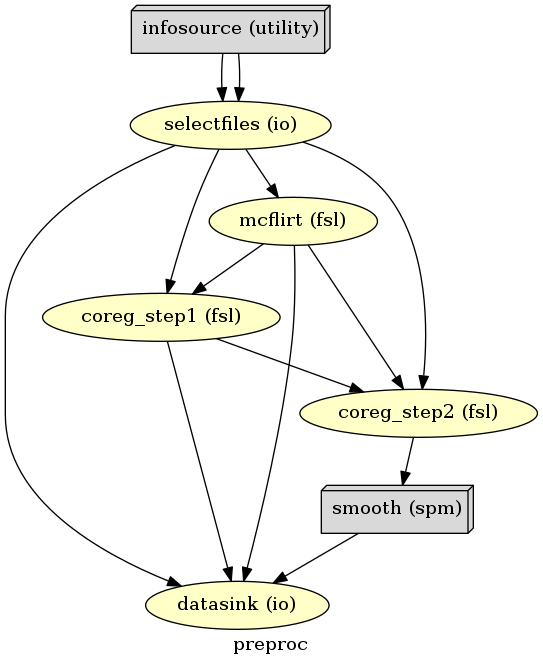

In [6]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

171211-11:00:34,773 workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir/preproc/graph.dot.png (graph2use=flat, simple_form=True).


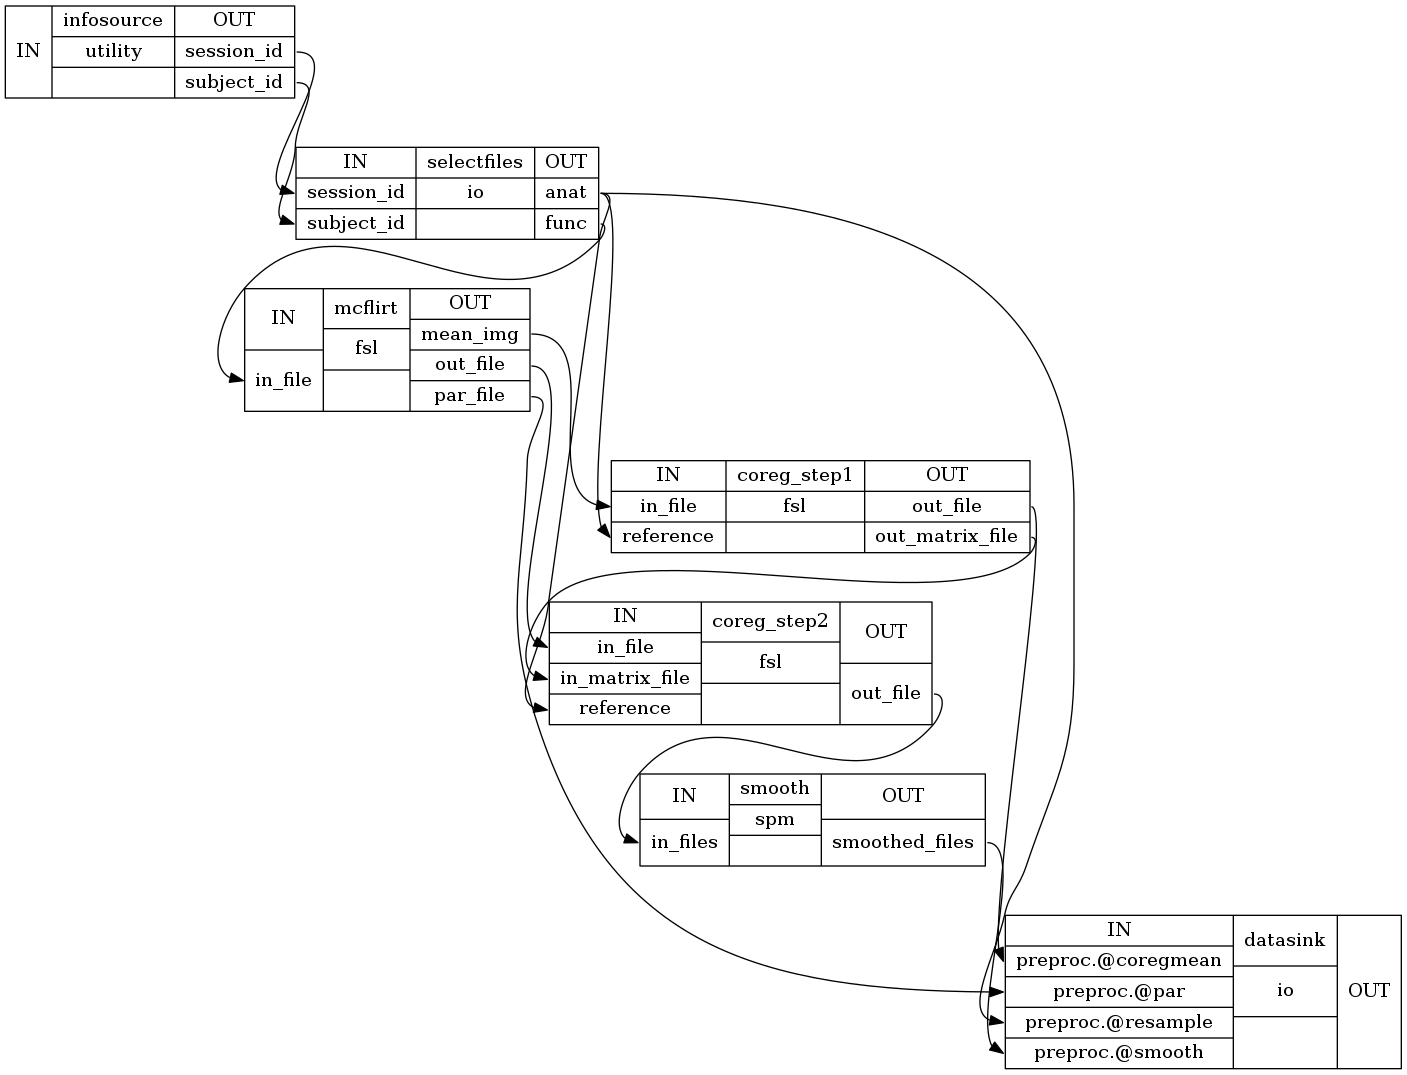

In [7]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [66]:
preproc.run('MultiProc', plugin_args={'n_procs': 10})

# !nipypecli crash /home/neuro/nipype_tutorial/crash-20171202-160850-neuro-resample.b11-28ee9940-3aa2-4176-bed8-e68cdda9bcd1.pklz

171211-12:15:48,549 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
171211-12:15:48,573 workflow INFO:
	 Running in parallel.
171211-12:15:48,581 workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 53.09/53.09, Free processors: 10/10.
171211-12:15:48,859 workflow INFO:
	 Executing node preproc.selectfiles in dir: /home/neuro/nipype_tutorial/output/workingdir/preproc/_session_id_run-3_subject_id_sub-1/selectfiles
171211-12:15:48,876 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.io.SelectFiles").
171211-12:15:50,581 workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
171211-12:15:50,585 workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 53.09/53.09, Free processors: 10/10.
171211-12:15:50,713 workflow INFO:
	 [Job 1] Cached (preproc.mcflirt).
171211-12:15:52,732 workflow INFO:
	 [Job 2] Cached (preproc.coreg_step1).
171211-12:15:54,734 workflow INFO:
	 [Job 3] 

# Plot Motion Parameters
Now, let's investigate the motion parameters. How much did the subject move and turn in the scanner?

In [ ]:
import numpy as np
import pylab as plt

par_file = '/home/neuro/nipype_tutorial/output/datasink/preproc/_session_id_run-13_subject_id_sub-1/sub-1_run-13_bold_mcf.nii.par'
par = np.loadtxt(par_file)

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

********************************************************************

# 1st-level Analysis using GLM

In this part we will take the preprocessed output from the first part and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

**So, let's begin!**

# Imports

First, we need to import all modules we later want to use.

In [2]:
%pylab inline
from os.path import join as opj
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib
171212-02:46:30,92 interface WARNING:
	 Could not get linked libraries for "which".


# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [10]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate.

In [11]:
# Condition names
condition_names = ['rest', 'right', 'left']

# Contrasts
contL1= 'right > rest'
contL2= 'left > rest'

contL7= 'right or left'

cont01 = [contL1,      'T', condition_names, [-1, 1, 0]]
cont02 = [contL2,    'T', condition_names, [-1, 0, 1]]

cont03 = [contL7,    'F', [cont01, cont02]]

contrast_list = [cont01, cont02, cont03]

# Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for first run for subject 1:

In [12]:
!cat {data_dir}sub-1/func/sub-1_{session_list[0]}_events.tsv

onset	duration	stimulus
0	2	right
2	2	right
4	2	right
6	2	right
8	2	right
10	2	right
12	2	left
14	2	left
16	2	left
18	2	left
20	2	left
22	2	left
24	2	right
26	2	right
28	2	right
30	2	right
32	2	right
34	2	right
36	2	left
38	2	left
40	2	left
42	2	left
44	2	left
46	2	left


So what we need is the onset and the stimuli type, i.e. **column 0** and **column 2**.

Now, let us incorporate all this information in the helper function subjectinfo to get the GLM model.

**Note that since the helper function will be defined as a node, all imports and variables should be redefined.**

In [3]:
def subjectinfo(subject_id, session_id):

    import numpy as np
    import json
    from os.path import join as opj
    from nipype.interfaces.base import Bunch
    
    data_dir = '/home/neuro/nipype_tutorial/data/'
    
    
    condition_names = ['rest', 'right', 'left']
    

    logfile_dir = opj(data_dir, subject_id, 'func')

    # Read the TSV file
    filename = opj(logfile_dir,
                   '%s_%s_events.tsv' % (subject_id, session_id))

    # Save relevant information
    trailinfo = np.genfromtxt(filename, delimiter='\t',
                              dtype=None, skip_header=1)
    trailinfo = [[t[0], t[2]] for t in trailinfo]

    # Separate onset of conditions
    onset1 = []
    onset2 = []
    onset3 = []


    for t in trailinfo:
        if b'rest' in t[1]:
            onset1.append(t[0])
        if b'right' in t[1]:
            onset2.append(t[0])
        if b'left' in t[1]:
            onset3.append(t[0])


    subjectinfo = [Bunch(conditions=condition_names,
                         onsets=[onset1, onset2, onset3],
                         durations=[[2.0], [2.0], [2.0]],
                         amplitudes=None,
                         tmod=None,
                         pmod=None,
                         regressor_names=None,
                         regressors=None)]


    return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id', 'session_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [ ]:
subjectinfo('sub-1', 'run-3')

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [36]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'session_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('session_id', session_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '_session_id_{session_id}_subject_id_{subject_id}',
                         '_fwhm_{fwhm_id}', 's{subject_id}_{session_id}_bold_mcf_flirt.nii'),
# # Here the unpreprocessed data is used for GLM analyis
# template = {'func': opj(data_dir, '{subject_id}', 'func',
#                 '{subject_id}_{session_id}_bold.nii'),             
             'mc_param': opj(output_dir, 'preproc', '_session_id_{session_id}_subject_id_{subject_id}',
                             '{subject_id}_{session_id}_bold_mcf.nii.par')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [37]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('session_id', 'session_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id', 'subject_id'),
                                                 ('session_id', 'session_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param',
                                               'realignment_parameters')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

171211-11:13:28,145 workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/output/workingdir/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).


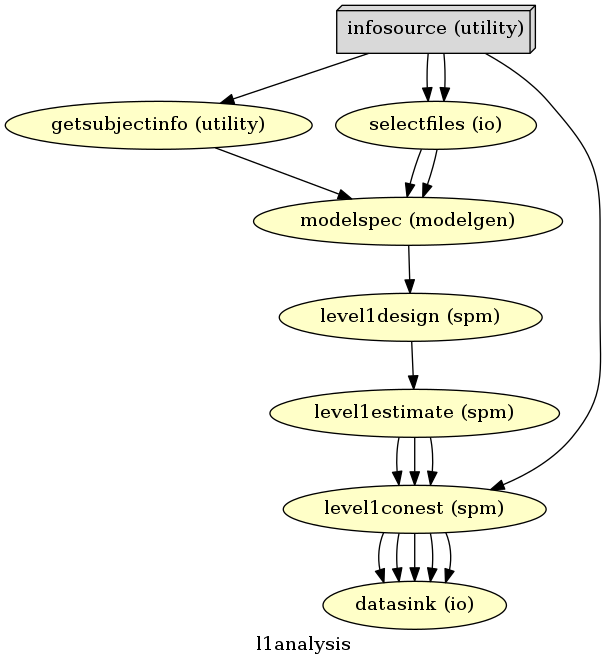

In [38]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

In [ ]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [41]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 10})

# !nipypecli crash /home/neuro/nipype_tutorial/crash-20171203-084943-neuro-getsubjectinfo.a0-ff371092-d758-40cb-a8ea-546235f16065.pklz

171211-11:15:56,464 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
171211-11:15:56,490 workflow INFO:
	 Running in parallel.
171211-11:15:56,496 workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 53.09/53.09, Free processors: 4/4.
171211-11:15:56,645 workflow INFO:
	 [Job 0] Cached (l1analysis.getsubjectinfo).
171211-11:15:56,653 workflow INFO:
	 Executing node l1analysis.selectfiles in dir: /home/neuro/nipype_tutorial/output/workingdir/l1analysis/_fwhm_id_4_subject_id_sub-1/selectfiles
171211-11:15:56,669 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.io.SelectFiles").
171211-11:15:58,497 workflow INFO:
	 [Job 1] Completed (l1analysis.selectfiles).
171211-11:15:58,500 workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 53.09/53.09, Free processors: 4/4.
171211-11:15:58,582 workflow INFO:
	 Executing node l1analysis.modelspec in dir: /home/neuro/nipype_tutorial/

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [44]:
!tree {output_dir}/1stLevel

/home/neuro/nipype_tutorial/output/datasink/1stLevel
└── sub-1_fwhm4
    ├── con_0001.nii
    ├── con_0002.nii
    ├── con_0003.nii
    ├── con_0004.nii
    ├── ess_0005.nii
    ├── ess_0006.nii
    ├── ess_0007.nii
    ├── spmF_0005.nii
    ├── spmF_0006.nii
    ├── spmF_0007.nii
    ├── SPM.mat
    ├── spmT_0001.nii
    ├── spmT_0002.nii
    ├── spmT_0003.nii
    └── spmT_0004.nii

1 directory, 15 files


# Visualize results

Let's look at the contrasts of one subject that we've just computed using the anatomical coregistration.

In [1]:
from nilearn.plotting import plot_stat_map
anatimg = data_dir+'sub-1/anat/sub-1_run-3_T1w.nii'
cut_coords=(35, -10, 55)
threshold = 4


contrasts_dir = output_dir + '/1stLevel/_fwhm_id_4_session_id_run-13sub-1'
plot_stat_map(
    contrasts_dir+'/spmT_0001.nii', title=contL1,
    bg_img=anatimg, threshold=threshold, cut_coords=cut_coords, dim=-1)

cut_coords=(-30, -10, 55)
plot_stat_map(
    contrasts_dir+'/spmT_0002.nii', title=contL2,
    bg_img=anatimg, threshold=threshold, cut_coords=cut_coords, dim=-1)


plot_stat_map(
    contrasts_dir+'/spmF_0003.nii', title=contL7,
    bg_img=anatimg, threshold=threshold, cut_coords=cut_coords, dim=-1)

ImportError: No module named nilearn.plotting

In [ ]:
import matplotlib.pyplot as plt
from nibabel.testing import data_path
import nibabel as nib

filename = opj(output_dir, 'preproc', '_session_id_run-13_subject_id_sub-1',
                         '_fwhm_4', 'ssub-1_run-13_bold_mcf_flirt.nii')

filename = opj(data_dir, 'sub-1', 'func', 'sub-1_run-13_bold.nii')
img = nib.load(filename)
print(img.shape)

plt.figure(figsize=(7, 5))
plt.plot(img.dataobj[32, 32, 14, :])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
# plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

show()